In [1]:
# %cd ..
import numpy as np, matplotlib.pyplot as plt
import inputs, simuls, analysis
from analysis import iso_in_plots
results = analysis.GetResults(verbose=True)

# PenEasy SPC simulation

In [2]:
pids = ['SPC', 'NUC']
ver = '24'
# Initialize PenEasy Input Editor
peneasy_inps = inputs.PenEasy(verbose=True)

# Initialize Simulators (identified by pid)
peneasy_sims = simuls.PenEasy(verbose=True)
for pid in pids:
    peneasy_sims.activate_pid(pid, ver)

penEasy 2024 SPC activated
penEasy 2024 NUC activated


In [3]:
MATS = {'water' : ['water', 1, 1.00+00]}
SIZE = [20]*3
STEP = [0.3]*3  #cm
nhist = "1e6"

# Same for both pids
peneasy_inps.edit_voxSize(pid, SIZE, STEP)
peneasy_inps.edit_seed(pid, 12345, 54321)
peneasy_inps.edit_mat(pid, MATS, SIZE, STEP)
peneasy_inps.edit_source_nhist(pid, nhist)

"penEasy/pen??_spc.in" and "penEasy/pen??_nuc.in" coordinates of box center modified to (3, 3, 3)
"penEasy/phantomN.vox" voxel size modified to (0.3, 0.3, 0.3)
"penEasy/pen*.in" random seeds modified to 12345 and 54321
"penEasy/pen??_spc.in" and "penEasy/pen??_nuc.in" material modified to water
"penEasy/phantomN.vox" density modified to 1.000000
"penEasy/phantomN.vox" updated to water (case 1)
"penEasy/pen??_spc.in" and "penEasy/pen??_nuc.in" number of histories modified to 1e6
"penEasy/phantomN.vox" updated to point source of activity 1e6


In [9]:
isotopes = ["C11", "N13", "O15", "F18", "Cu64", "Ga68", "Rb82", "I124"]
isotopes = ["Cu64", "Ga68", "Rb82", "I124"]

peneasy_inps.verbose = False
pid = 'NUC' # SPC already done
for iso in isotopes:
    print(f"Simulating {iso}")
    res_folder = f"RESULTS/{pid}/Water/PenEasy20{ver}_xyz"
    peneasy_inps.edit_isotope(pid, iso)
    match iso:
        case "C11" | "N13" | "O15" | "F18":
            nh = nhist
        case "Cu64" | "I124":
            nh = str(float(nhist)*5)
        case "Ga68" | "Rb82":
            nh = str(float(nhist)*1.2)
    peneasy_inps.edit_source_nhist(pid, nh)
    peneasy_sims.simulate(pid, get_times=True, time_samples=1, output_dir=res_folder, final_file=f"{iso}.dat.original")

Simulating Cu64
penEasy 2024 NUC real time: 164.302 +- 0.000 s
Simulating Ga68
penEasy 2024 NUC real time: 148.762 +- 0.000 s
Simulating Rb82
penEasy 2024 NUC real time: 176.353 +- 0.000 s
Simulating I124
penEasy 2024 NUC real time: 253.285 +- 0.000 s


In [5]:
res_folder = f"RESULTS/{pid}/Water/PenEasy20{ver}_xyz"
times_file = res_folder + "/" + pid + "_times.txt"
times = np.loadtxt(times_file).astype("str")
times[:,1], times[:,0] = times[:,0], isotopes
np.savetxt(times_file, times, fmt='%s')

# vGATE 9.x simulation

In [2]:
pid = '9'
# Initialize GATE Input Editor
gate_inps = inputs.GATE(verbose=True)

# Initialize Simulators (identified by pid)
gate_sims = simuls.GATE(verbose=True)
gate_sims.activate_pid(pid, output_format='dat')

GATE 9 activated


In [3]:
MATS = {'water' : ['Water', 6, 1.00+00]}
SIZE = [20]*3
STEP = [0.3]*3  #cm
nhist = "3e6"

gate_inps.edit_voxSize(pid, SIZE, STEP)
gate_inps.edit_seed(pid)
gate_inps.edit_mat(pid, MATS, SIZE, STEP)
gate_inps.edit_source_nhist(pid, nhist)
gate_inps.switch_emission(pid, emis='NUC')

"gate/mac/actors/ProdStop.mac" voxel dimensions modified to (20, 20, 20) and total size to (6, 6, 6) cm
"gate/phantom/ACTIVITY.h33" and "gate/phantom/MATERIAL.h33" voxel dimensions modified to (20, 20, 20)
"gate/phantom/ACTIVITY.h33" and "gate/phantom/MATERIAL.h33" voxel size modified to (3, 3, 3) mm
"gate/mac/phantoms/analytical/1mat.mac" resized
"gate/mac/phantoms/analytical/2mat.mac" resized
"gate/mac/phantoms/analytical/3mat.mac" resized
"gate/mac/sources/shape/cylinder*.mac" halfz resized
"gate/PR_GATEv7.mac gate/PR_GATEv9.mac" random seed modified to 39609
"mac/phantoms/analytical/1mat.mac" materials modified to Water (case 1)
"gate/PR_GATEv9.mac" number of histories modified to 3e6
"gate/PR_GATEv9.mac" mode modified to NUC


In [4]:
isotopes = ["C11", "N13", "O15", "F18", "Cu64", "Ga68", "Rb82", "I124"] #
isotopes = ["I124"]
res_folder = "RESULTS/NUC/Water/GATE93_xyz"

gate_inps.verbose = False
for iso in isotopes:
    print(f"Simulating {iso}")
    gate_inps.edit_isotope(pid, iso)
    gate_sims.simulate(pid, get_times=True, time_samples=1, output_dir=res_folder, final_file=f"{iso}.dat.original")


Simulating I124
GATE 9 real time: 3231.124 +- 0.000 s


In [6]:
times_file = res_folder + "/" + pid + "_times.txt"
times = np.loadtxt(times_file).astype("str")
times[:,1], times[:,0] = times[:,0], isotopes
np.savetxt(times_file, times, fmt='%s')

# Results analysis

In [5]:
program_folder = "GATE93_xyz"
etype = 'NUC'
folder = f"RESULTS/{etype}/Water/{program_folder}"
trim = int(1e6)

rthresh = {"C11" : 5, "N13" : 6, "O15" : 9, "F18" : 3, "Cu64" : 4, "Ga68" : 10, "Rb82" : 17.5, "I124" : 12}  #water

for iso in rthresh.keys():
    # if iso != "Cu64": continue
    if program_folder == "GATE7_xyz" and iso not in ["C11", "O15", "F18"]:
        continue
    print(f"Filtering {iso}")
    threshold = rthresh[iso] #mm
    analysis.filter_rmax(f"{folder}/{iso}.dat.original", f"{folder}/{iso}.dat", threshold=threshold, trim=trim, fmt='%.6f')

Filtering C11
Filtered 'RESULTS/NUC/Water/GATE93_xyz/C11.dat.original' to 'RESULTS/NUC/Water/GATE93_xyz/C11.dat': 0 points removed
Filtering N13
Filtered 'RESULTS/NUC/Water/GATE93_xyz/N13.dat.original' to 'RESULTS/NUC/Water/GATE93_xyz/N13.dat': 0 points removed
Filtering O15
Filtered 'RESULTS/NUC/Water/GATE93_xyz/O15.dat.original' to 'RESULTS/NUC/Water/GATE93_xyz/O15.dat': 2 points removed
Filtering F18
Filtered 'RESULTS/NUC/Water/GATE93_xyz/F18.dat.original' to 'RESULTS/NUC/Water/GATE93_xyz/F18.dat': 0 points removed
Filtering Cu64
Filtered 'RESULTS/NUC/Water/GATE93_xyz/Cu64.dat.original' to 'RESULTS/NUC/Water/GATE93_xyz/Cu64.dat': 5 points removed
Filtering Ga68
Filtered 'RESULTS/NUC/Water/GATE93_xyz/Ga68.dat.original' to 'RESULTS/NUC/Water/GATE93_xyz/Ga68.dat': 2 points removed
Filtering Rb82
Filtered 'RESULTS/NUC/Water/GATE93_xyz/Rb82.dat.original' to 'RESULTS/NUC/Water/GATE93_xyz/Rb82.dat': 17 points removed
Filtering I124
Filtered 'RESULTS/NUC/Water/GATE93_xyz/I124.dat.original' 

In [2]:
histo_bins = 401
histo_step = 5e-2/10 #mm
isotopes = ["C11", "N13", "O15", "F18", "Cu64", "Ga68", "Rb82", "I124"] 
pfolders = {
    "PenEasy 2024":"PenEasy2024_xyz",
    "GATE 9.3":"GATE93_xyz",
}
etypes = {
    'NUC':'simul. ion decay',
    'SPC':'spec. from PENNUC',
    'SPC_GATE':'spec. from GATE',
}

labels_iso = {etype: {iso: [] for iso in isotopes} for etype in etypes.keys()}
labels_prg = {etype: {p: [] for p in pfolders.keys()} for etype in etypes.keys()}

results.active_results.clear()
for iso in isotopes:
    for pname, pfolder in pfolders.items():
        for etype in etypes.keys():
            if etype == 'SPC_GATE' and (iso not in ["C11", "O15", "F18"] or "GATE" not in pname): continue
            # file with results
            rf = f"RESULTS/{etype}/Water/{pfolder}/{iso}.dat"
            # result label
            rl = f"{pname} {iso} {etype}"

            # load results
            hbin = histo_bins
            hstep = histo_step * (2 if iso in ["Ga68", "Rb82", "I124"] else 1)
            results.load(rl, rf, [hbin]*3, [hstep]*3)

            # append label to labels
            labels_iso[etype][iso].append(rl)
            labels_prg[etype][pname].append(rl)

PenEasy 2024 C11 NUC loaded
PenEasy 2024 C11 SPC loaded
GATE 9.3 C11 NUC loaded
GATE 9.3 C11 SPC loaded
GATE 9.3 C11 SPC_GATE loaded
PenEasy 2024 N13 NUC loaded
PenEasy 2024 N13 SPC loaded
GATE 9.3 N13 NUC loaded
GATE 9.3 N13 SPC loaded
PenEasy 2024 O15 NUC loaded
PenEasy 2024 O15 SPC loaded
GATE 9.3 O15 NUC loaded
GATE 9.3 O15 SPC loaded
GATE 9.3 O15 SPC_GATE loaded
PenEasy 2024 F18 NUC loaded
PenEasy 2024 F18 SPC loaded
GATE 9.3 F18 NUC loaded
GATE 9.3 F18 SPC loaded
GATE 9.3 F18 SPC_GATE loaded
PenEasy 2024 Cu64 NUC loaded
PenEasy 2024 Cu64 SPC loaded
GATE 9.3 Cu64 NUC loaded
GATE 9.3 Cu64 SPC loaded
PenEasy 2024 Ga68 NUC loaded
PenEasy 2024 Ga68 SPC loaded
GATE 9.3 Ga68 NUC loaded
GATE 9.3 Ga68 SPC loaded
PenEasy 2024 Rb82 NUC loaded
PenEasy 2024 Rb82 SPC loaded
GATE 9.3 Rb82 NUC loaded
GATE 9.3 Rb82 SPC loaded
PenEasy 2024 I124 NUC loaded
PenEasy 2024 I124 SPC loaded
GATE 9.3 I124 NUC loaded
GATE 9.3 I124 SPC loaded


In [3]:
results.data_analysis()

Size of annihilations sample:
     PenEasy 2024 C11 NUC                    	    997609
     PenEasy 2024 C11 SPC                    	   1000000
     GATE 9.3 C11 NUC                        	    998126
     GATE 9.3 C11 SPC                        	   1000000
     GATE 9.3 C11 SPC_GATE                   	    100045
     PenEasy 2024 N13 NUC                    	    998213
     PenEasy 2024 N13 SPC                    	   1000000
     GATE 9.3 N13 NUC                        	    998590
     GATE 9.3 N13 SPC                        	   1000000
     PenEasy 2024 O15 NUC                    	    998890
     PenEasy 2024 O15 SPC                    	   1000000
     GATE 9.3 O15 NUC                        	    999954
     GATE 9.3 O15 SPC                        	   1000000
     GATE 9.3 O15 SPC_GATE                   	    100118
     PenEasy 2024 F18 NUC                    	    968754
     PenEasy 2024 F18 SPC                    	   1000000
     GATE 9.3 F18 NUC                        	    967473
 

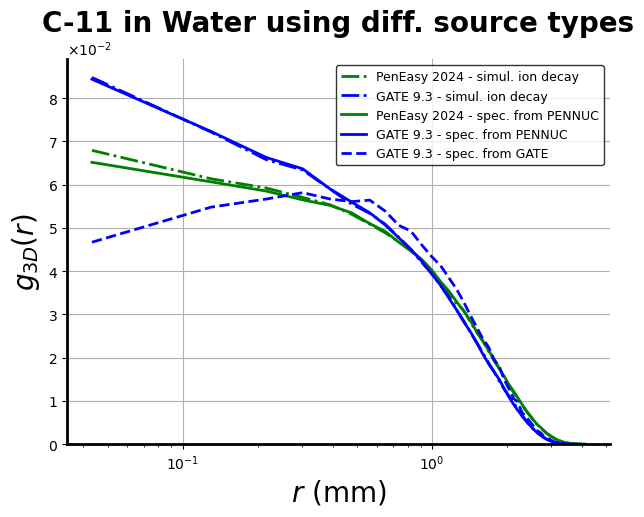

In [13]:
iso = "C11"
lt = ['-.', '-', '--']
lt = dict(zip(etypes.keys(), lt))
c = {'PenEasy 2024':'g', 'GATE 9.3':'b'}
isop = iso_in_plots(iso)

l = sum(list(labels_iso[etp][iso] for etp in labels_iso.keys()), [])
fmts = [c[p]+lt[etp] for etp in etypes.keys() for p in pfolders.keys() if (etp != 'SPC_GATE' or 'GATE' in p)]
sl = [p+" - "+letp for etp, letp in etypes.items() for p in pfolders.keys() if (etp != 'SPC_GATE' or 'GATE' in p)]

fmts = dict(zip(l, fmts))
sl = dict(zip(l, sl))

plt.figure(figsize=(7,5))
results.plot_g3D(lim=None, log_scale=False, labels=l, sublabels=sl, title=f"{isop} in Water using diff. source types", fmt=fmts)
plt.xscale('log')
plt.show()

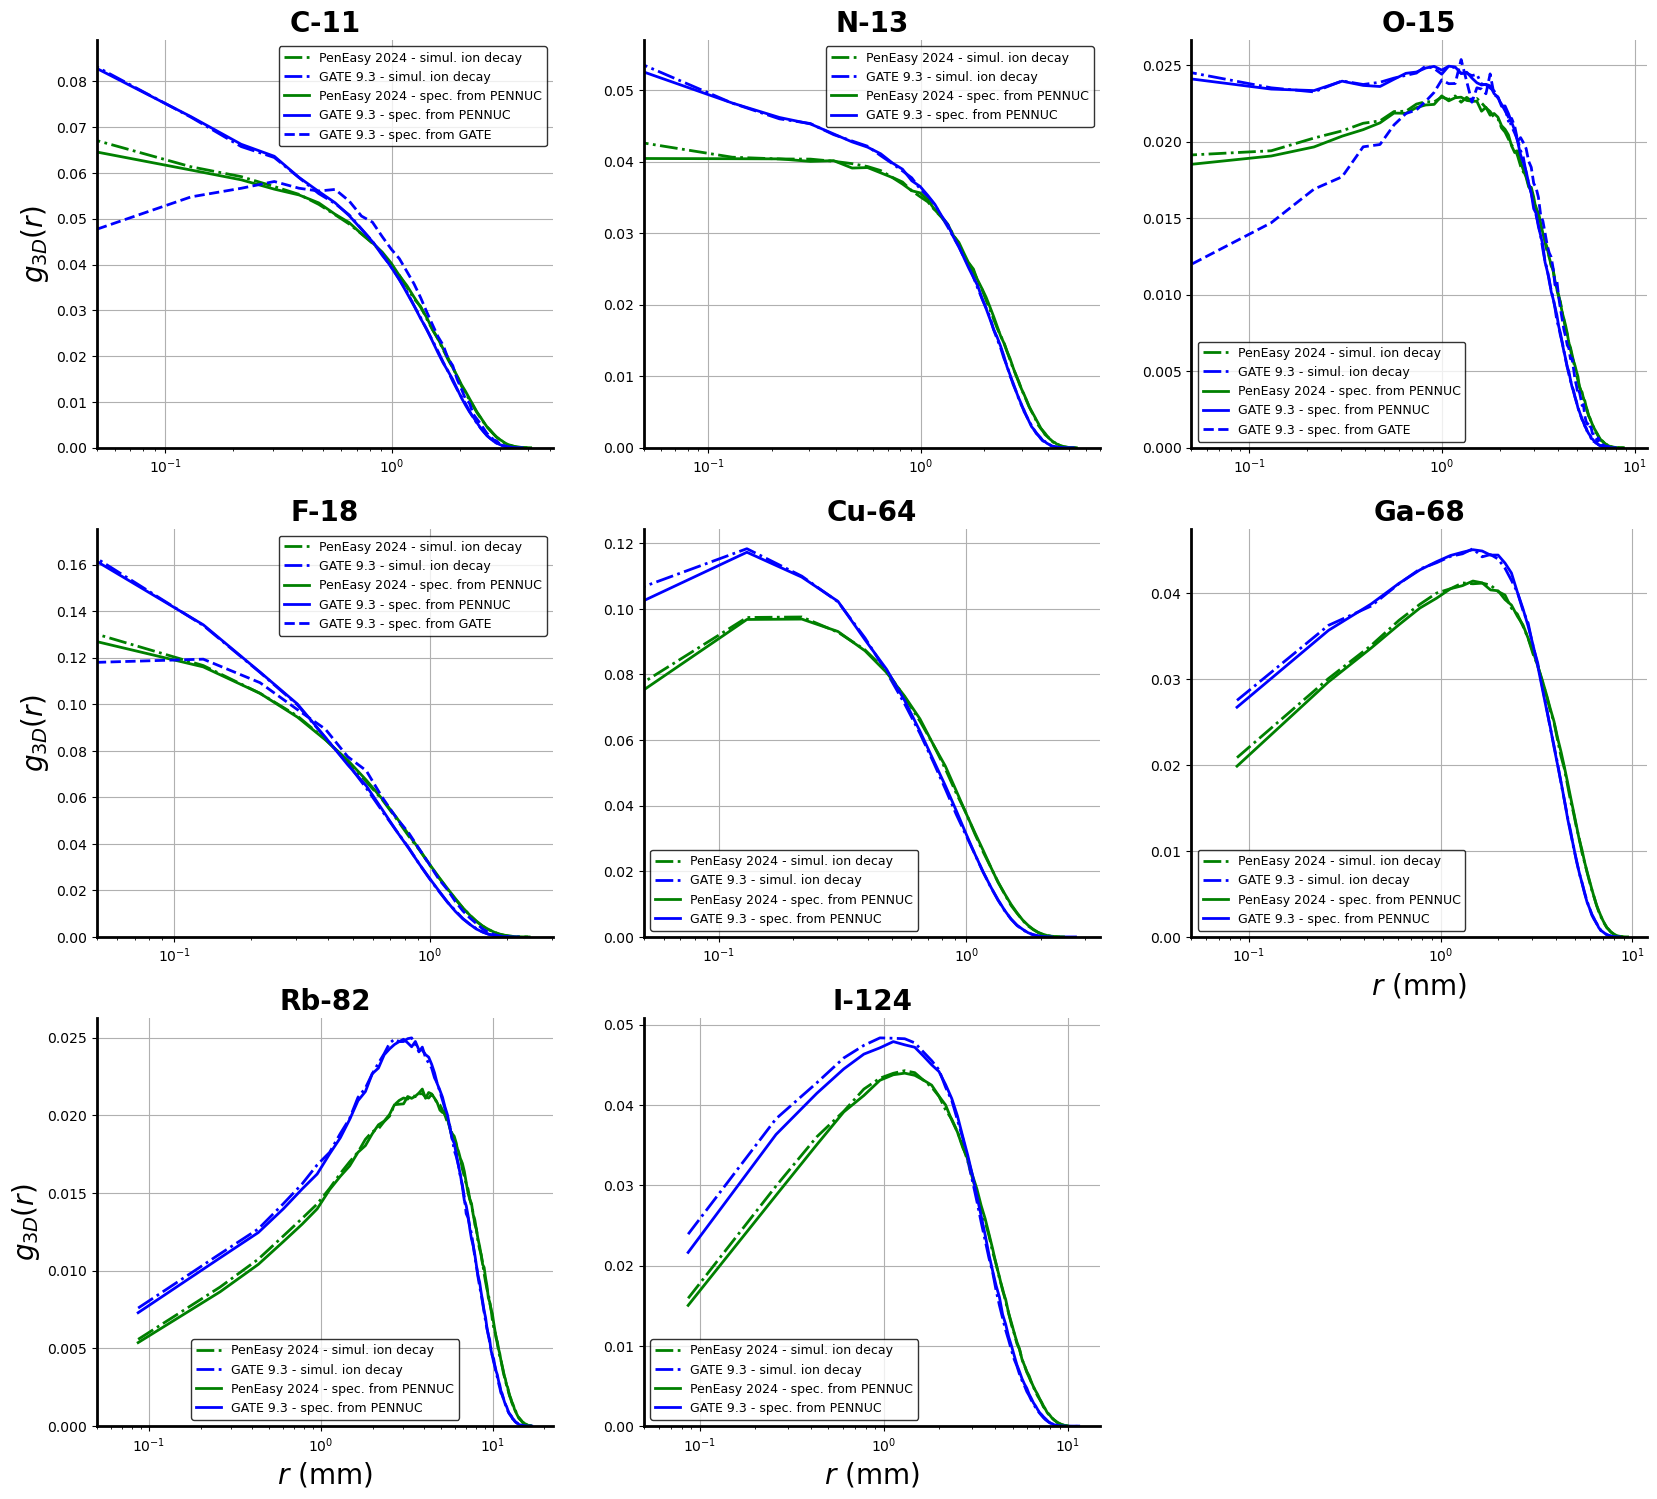

In [7]:
lt = ['-.', '-', '--']
lt = dict(zip(etypes.keys(), lt))
c = {'PenEasy 2024':'g', 'GATE 9.3':'b'}

kmax = len(isotopes)
# isop = list(map(iso_in_plots, isotopes))
max_cols = 3
max_rows = int(np.ceil(kmax/max_cols))
plt.figure(figsize=(20,6*max_rows))
for k, iso in enumerate(isotopes):
    isop = iso_in_plots(iso)
    l = sum(list(labels_iso[etp][iso] for etp in labels_iso.keys()), [])
    fmts = [c[p]+lt[etp] for etp in etypes.keys() for p in pfolders.keys() if (etp != 'SPC_GATE' or 'GATE' in p)]
    fmts = dict(zip(l, fmts))
    sl = [p+" - "+letp for etp, letp in etypes.items() for p in pfolders.keys() if (etp != 'SPC_GATE' or 'GATE' in p)]
    sl = dict(zip(l, sl))
    plt.subplot(max_rows, max_cols, k+1)
    # results.plot_g3D(labels=l, sublabels=sl, title=f" ", legend_size=10, log_scale=False)
    ### final results
    plt.title(f"{isop}", fontsize=20, fontweight='bold')
    if k >= kmax-max_cols:
        plt.xlabel(r"$r$ (mm)", fontsize=20)
    if k % max_cols == 0:
        plt.ylabel(r"$g_{3D}(r)$", fontsize=20)

    for l, p in sl.items():
        res = results.active_results[l]
        plt.plot(res.rplot*10, res.g3D, fmts[l], label=f"{p}", linewidth=2)
    analysis.aesthetic_plot(legend_size=9)
    ###

    plt.xscale("log")
    plt.xlim(5e-2, None)
plt.show()